#### Summary:
In this notebook I'll create importance score plots for peaks at the Lepr locus. For now, I'll just use previously developed methods to find all peaks in my previously generated importance scores at a particular loci. However, I want to extract them for all 4 models I made, so this might get a bit complicated bc I have 2 sets of importance score peaks which may or may not line up (will have to see).

In [14]:
from __future__ import print_function
import numpy as np
import pandas as pd
from collections import Counter
import sys
import random
import os
import fnmatch
import sys
from Bio import SeqIO
from Bio.Seq import Seq
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
dataDirectory = '/home/h1bennet/strains/data/ATAC/control_cohort2/'
workingDirectory = '/home/h1bennet//strains_machinelearning/results/00_New_ATAC_H3K27Ac_Model/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

# Define functions

In [16]:
def load_genome(ref_path):
    ref_dict = {}
    for seq in SeqIO.parse(ref_path, "fasta"):
        chromID = seq.id
        chromSeq = (str(seq.seq)).upper()
        ref_dict[chromID] = chromSeq
    return ref_dict

ref_path = "/home/zes017/genomes/mm10/mm10.fa"
genomes = load_genome(ref_path)

def data_prep(path, genomes, label, strain, size=500, rep=1, shift=None):
    print ("Scaled to %d" % (size))
    if shift is None:
        shifts = size//rep*np.arange(-rep//2+1,rep//2+1)
    elif type(shift) is int:
        shifts = np.abs(shift)*np.arange(-rep//2+1,rep//2+1)
    elif type(shift) is list:
        if len(shift) != rep:
            raise TypeError("Number of shift unequal to replicates")
        shifts = np.array(shift)
    if rep == 1 and shift is not None:
        random_shift = True
        print("Random shifting within %s" % (str(-np.abs(shift))+'~'+str(np.abs(shift))))
    else:
        random_shift = False
        print("Generate replicates by shifting %s bp" % (','.join(shifts.astype(str))))
    
    data_list = []
    for line in open(path):
        elems = line.split()
        chromID = elems[0]
        start, end = int(elems[1]), int(elems[2])
        length = end-start
        mid = (start+end)//2
        for s in shifts:
            if random_shift:
                new_mid = mid + np.random.choice(np.arange(-np.abs(shift), np.abs(shift)+1))
            else:
                new_mid = mid + s
            start = new_mid - size//2
            end = new_mid + size//2
            seq = genomes[chromID][start:end]
            if len(seq) != size:
                continue
                
            #created combined name term, ex: chr5_140648065_140648415_C57
            k = chromID + "_" + str(start) + "_" + str(end) + "_" + strain

            data_point = (seq, label, chromID, start, end, k)
            data_list.append(data_point)
    return data_list

def findOverlapPeaks(peak, pos_data):
    '''Function to find overlapping regions of the genome. Written by H.
    Mummey and edited by H. Bennett. Main edit by H. Bennett was to use
    integer ranges as a lazy way of determining overlap between peaks.
    Accepts:
    - peak (list): list of position data for target peak containing
    [chr (str), start (int), end (int)]
    - pos_data (list): list of positional data with each entry holding sequence,
    chr, start, end, and an ID.
    
    Returns:
    overlapping_peaks (list): list of entries in pos_data overlapping
    target peak'''
    overlapping_peaks = []
    
    for i in range(len(pos_data)):
        # for each iteration make a peak list
        data_peak = [pos_data[i][2], pos_data[i][3], pos_data[i][4]]
        
        # check whether on same chromosome
        if pos_data[i][2] == peak[0]:
            
            # generate ranges 
            ref_peak = set(np.arange(pos_data[i][3], pos_data[i][4]+1))
            test_peak = set(np.arange(peak[1], peak[2]+1))
            
            if len(ref_peak.intersection(test_peak)) > 0:
                print("overlap found", pos_data[i][-1])
                overlapping_peaks.append(pos_data[i])
            
    return overlapping_peaks

def FindVariants(variant_df, peak):

    '''Accepts:
    - variant_df (pd.DataFrame) produced by MMARGE annotate mutations.
    should be a peak file with the peakIDs absent or set as index so that 
    - peak (list) list produced by Hannah's wrapping programs
    with the following items: [chr (string), start (int), end (int)]
    

    returns:
    - balb_vars (list): list of positions within given region in peak
    containing a genomic mutation
    '''
    
    #find variants that overlap with a given peak
    balb_vars = []
    
    #first record all rows of variants_df that have ranges that overlap with chr_pos
    overlapping_peaks = []
    
    # filter based on chr membership to save time
    variant_df_same_chr = variant_df.loc[variant_df.loc[:, 'chr']==peak[0], :]
    
    for row in variant_df_same_chr.iterrows(): #manual search
        # var_peak = [row[1].chr, row[1].start, row[1].end]
        var_peak_range = set(np.arange(row[1].start, row[1].end)+1)
        test_peak_range = set(np.arange(peak[1], peak[2])+1)
        
        if len(var_peak_range.intersection(test_peak_range)) > 0:
            print("overlap found", row[0])
            overlapping_peaks.append(row[0])
            
    #then record which variants are in the chr_pos range
    for overlap in overlapping_peaks:
        b_vars = variant_df.loc[overlap, 'BALBCJ - 1']        
        if (type(b_vars)) == str:
            parse1 = str(b_vars).split(",")
            for var in parse1:
                parse2 = var.split(":")
                balb_vars.append(int(parse2[0]))


    return balb_vars

def OverlayVariantsGen2(variant_df, smooth_weights, pos_data, chr_pos, model,
                        ylim=1, scatter_kws={'s':10, 'c':'#636363'},
                        hline_kws={'c':'#bdbdbd','linestyle':'--','linewidth':1},
                        vline_kws={'c':'#3182bd','linestyle':'--','linewidth':1},
                        ax=None):
    '''Function to overlay variants with the smoothed deep lift importance
    scores. Written by H. Mummey and modified by H. Bennett. One thing
    to fix is how to access columns of variant DF.
    Accepts:
    - variant_df (pandas DataFrame): peak file with annotations of mutations.
    Requires that either peakIDs are set as index or not included (chr must be
    in column 1)
    - smooth_wights (numpy array): array of deeplift weights(?)
    - pos_data (list): list of positional data with each entry holding sequence,
    chr, start, end, and an ID.
    - chr_pos: string of chr position, this is usually pulled from the pos_data list
    of ids which has the structure chr_start_end, so the chrom position can be pulled
    using a string split on "_"
    - model (str): model used, i think this is just for titling the plot
    - ylim (int): set limit of y axis manually
    
    Returns:
    - ax (matplotlib axes object): plot of deepbind score with overlying variants.
    '''
    
    #deconstruct chr_pos
    peak = chr_pos.split("_")
    peak = peak[:3]
    peak[1] = int(peak[1])
    peak[2] = int(peak[2])
    
    #find variants
    balb_vars = FindVariants(variant_df, peak)
    # print("variants", balb_vars)
    
    #now output a figure where we draw vertical lines for variants
    #reconstruct the pos_data style s
    s = chr_pos
    
    # if axis don't exist, create them
    if ax == None:
        fig, ax = plt.subplots(figsize=(17,5))

    # extract weights
    w = np.abs(smooth_weights[np.array(pos_data)[:,-1] == s][0])
    
    # plot weights
    ax.scatter(np.arange(len(w)), w, zorder=10, **scatter_kws)
    
    # plot reference line
    ax.axhline(np.sort(w)[240], **hline_kws)

    # plot verticle lines for mutations
    for bvar in balb_vars:
        ax.axvline(bvar-peak[1], **vline_kws)

    # adjust plotting parameters                
    ax.set_xlim(0,300)
    ax.set_ylim(0,ylim)
    ax.set_title(model + ": " + chr_pos)
    ax.set_xlabel('position')
    ax.set_ylabel('abs. DeepLIFT score')
    ax.spines['right'].set_visible(False) # hide right spine
    ax.spines['top'].set_visible(False) # hide top spine
    
    plt.tight_layout()


# Read in MMARGE Variants

In [17]:
mutfile = "/home/h1bennet/strains_f1/data/annotate_mutations_merge_f0_f1.idr"
control_vars = pd.read_table(mutfile, sep='\t', index_col=0)
print(len(control_vars))
control_vars.head()

140427


,chr,start,end,strand,Stat,Parent files,Total subpeaks,f0_balb.idr,f0_c57.idr,f1_balb.idr,f1_c57bl6.idr,BALBCJ - 1
#name (cmd = mergePeaks f0_balb.idr f0_c57.idr f1_balb.idr f1_c57bl6.idr),,,,,,,,,,,,
Merged-chr11-98789029-4,chr11,98788880,98789152,+,1000.000000,f0_balb.idr|f0_c57.idr|f1_balb.idr|f1_c57bl6.idr,4,Merged-chr11-98789041-6,Merged-chr11-98788992-6,Merged-chr11-98789035-6,Merged-chr11-98789035-6,NaN
Merged-chr11-48775620-2,chr11,48775424,48775817,+,739.333374,f1_balb.idr|f1_c57bl6.idr,2,NaN,NaN,Merged-chr11-48775642-3,Merged-chr11-48775652-2,NaN
Merged-chr11-115858855-2,chr11,115858550,115859160,+,959.750000,f1_balb.idr|f1_c57bl6.idr,2,NaN,NaN,Merged-chr11-115858827-2,Merged-chr11-115858827-2,NaN
Merged-chr11-95354785-2,chr11,95354597,95354974,+,1000.000000,f1_balb.idr|f1_c57bl6.idr,2,NaN,NaN,Merged-chr11-95354800-3,Merged-chr11-95354800-3,NaN
Merged-chr11-75629486-2,chr11,75629264,75629708,+,950.750000,f1_balb.idr|f1_c57bl6.idr,2,NaN,NaN,Merged-chr11-75629518-2,Merged-chr11-75629518-2,75629685:T->C


# Reading in Importance Scores and Data


### Pos_data (overlap peaks predicted to be positive by BOTH models)

In [18]:
# poised set
data_path = "./bed_files/poised_active_merged_peaks_scored_poised_filtered.bed"
poised_data = data_prep(data_path, genomes, 1, "C57", size=300, rep=1, shift=None)
print(len(poised_data))

Scaled to 300
Generate replicates by shifting 0 bp
38482


In [19]:
# active set
data_path = "./bed_files/poised_active_merged_peaks_scored_active_filtered.bed"
active_data = data_prep(data_path, genomes, 1, "C57", size=300, rep=1, shift=None)
print(len(active_data))

Scaled to 300
Generate replicates by shifting 0 bp
43537


### Read in Weights

In [20]:
#saved weights from interpretation nb (will smooth here in case we need raw)
#read in raw weights
poised_weights = pd.read_csv("./region_scores/poised_model_poised_peak_weights.txt",
                                 sep='\t',
                                 index_col=0)
print(poised_weights.shape)
#print(poised_weights.head())

#now convert to a np array
poised_weights_array = np.array(poised_weights)
poised_weights_array[0,0:10]

(38482, 300)


array([-0.0001682 , -0.00011876, -0.0003104 , -0.00196401, -0.00297288,
       -0.00138692, -0.00246708,  0.00057517,  0.00171606, -0.00367359])

In [21]:
#saved weights from interpretation nb (will smooth here in case we need raw)
#read in raw weights
active_weights = pd.read_csv("./region_scores/active_model_active_peak_weights.txt",
                                 sep='\t',
                                 index_col=0)
print(active_weights.shape)
#print(active_weights.head())

#now convert to a np array
active_weights_array = np.array(active_weights)
active_weights_array[0,0:10]

(43537, 300)


array([-7.5058045e-04, -2.1890788e-03, -9.6546850e-05, -1.5507314e-03,
       -1.4194234e-04, -1.7118760e-03,  4.0145720e-04,  1.1002405e-03,
       -1.1146057e-03,  1.1454145e-03])

### Smooth Weights

In [22]:
proc_range = 1
poised_smooth_weights = np.array([[np.mean(np.abs(w[max(0, i-proc_range):min(len(w), i+proc_range+1)]))
                         for i in range(len(w))] for w in poised_weights_array])
print(poised_smooth_weights.shape)

(38482, 300)


In [23]:
proc_range = 1
active_smooth_weights = np.array([[np.mean(np.abs(w[max(0, i-proc_range):min(len(w), i+proc_range+1)]))
                         for i in range(len(w))] for w in active_weights_array])
print(active_smooth_weights.shape)

(43537, 300)


# Visualizations

In [64]:
test_peak = [('chr19', 17276081, 17276281),
             ('chr16', 45644567, 45644767),
             ('chr3',51184483,51185483),
             ('chr3',51185133,51186133),
             ('chr3',51183000,51186500),
             ('chr3',51182128,51187908)]

In [65]:
findOverlapPeaks(test_peak[5], poised_data)

overlap found chr3_51182530_51182830_C57
overlap found chr3_51185465_51185765_C57
overlap found chr3_51184830_51185130_C57


[('TTTGCACACCAGTGTTTACAGTCAGTCATTTGTATGCAAAACACATACAAAACCCTTTACTCAATCACTTTGTGAATAGGCAAGGATAAGTATTCAAGCAGGATGAAAGGGCTCCTCACCCTTGACCAGAGAAGAGTACAGGCCAGCTGGGTCAGATGGGCCACGGAAAAGATGAACTAGATTATTACGTAAGTTTCACTAAACTGTAATAATAAAAATACAGGGCTTTTTTTTCAGTGAACTGTCACTGGGTATACCAACCACACTCCAAGGAGTAGTTAGCCAAGACAAAACAAACGC',
  1,
  'chr3',
  51182530,
  51182830,
  'chr3_51182530_51182830_C57'),
 ('GAGTGCGGCAACACCTGGTATCACCTAATATGACCCCCCTTTGGAGGATGGGTAAACTTAATCCTGGAGTGGCATCATGTGCCAGGCATAAGAAACAGAAAGTACGAAGGCACAGAGGCGTGAAAATGCCTGAAGAGCAGCCAACACAGCCAGAACACGGAACTGGTGAGAGAGAACTAGGTTTGATTGGTTGGTTCCGGTCAGTCTTCAAGACACTGCTGAGTGCTGTGGAAAAGAACAACTTTCATCTGCAGCAGGAAGAAGCAAAGAGGCTTTTCTTACACACACACACACACACAC',
  1,
  'chr3',
  51185465,
  51185765,
  'chr3_51185465_51185765_C57'),
 ('CCTAACACACTGCAACGGTCAGGATCTAACCAGACAGGCAGAACCTGGGCTGAACGAGATCTATTGCAAGGACTTAGCTTACATAACTGTGGATCAGCTAAGCAAGTTCAAAATCCATAGGGCAGATGGCAAGCTGGAAGCCGCAGACGTCACGGAAAACCTGGTTCTGCTTTTACGGCAGATTAACTCCGTGTCACCCAGAAGAACAGTGACCGTACATCCCCTTCCTCCAAAATCCACG

overlap found Merged-chr3-51184970-4
overlap found Merged-chr3-51184970-4


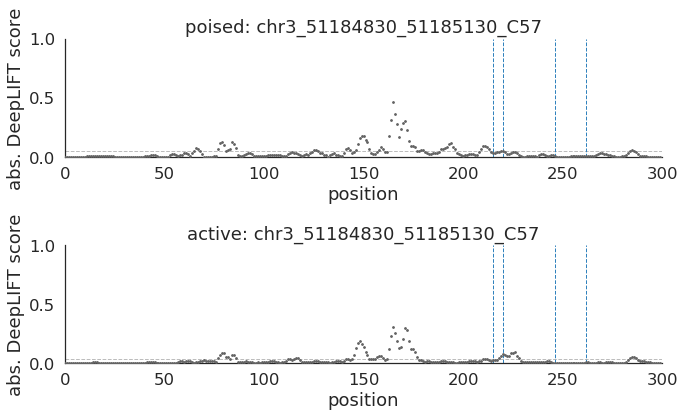

In [68]:
fig, axs = plt.subplots(2, 1, figsize=(10,6))

OverlayVariantsGen2(control_vars,
                    poised_smooth_weights,
                    poised_data,
                    'chr3_51184830_51185130_C57',
                    'poised', ylim=1, ax=axs[0],
                    scatter_kws={'s':3, 'c':'#636363'})

OverlayVariantsGen2(control_vars,
                    active_smooth_weights,
                    active_data,
                    'chr3_51184830_51185130_C57',
                    'active', ylim=1, ax=axs[1],
                    scatter_kws={'s':3, 'c':'#636363'})

overlap found Merged-chr19-17276209-3
overlap found Merged-chr19-17276209-3


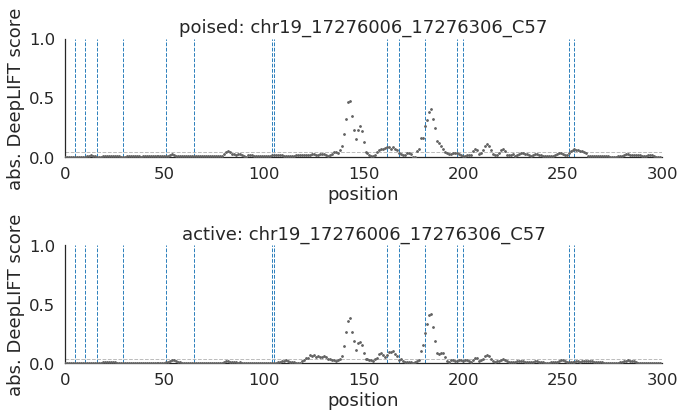

In [50]:
fig, axs = plt.subplots(2, 1, figsize=(10,6))

OverlayVariantsGen2(control_vars,
                    poised_smooth_weights,
                    poised_data,
                    'chr19_17276006_17276306_C57',
                    'poised', ylim=1, ax=axs[0],
                    scatter_kws={'s':3, 'c':'#636363'})

OverlayVariantsGen2(control_vars,
                    active_smooth_weights,
                    active_data,
                    'chr19_17276006_17276306_C57',
                    'active', ylim=1, ax=axs[1],
                    scatter_kws={'s':3, 'c':'#636363'})

chr3:51184483-51185483

In [11]:
lxr_locus = ['chr2',91183796,91195506]

In [12]:
findOverlapPeaks(lxr_locus, poised_data)

overlap found chr2_91183845_91184145_C57


[('CCTAACAGACACAGGCTTGCTCTGACAGGGCGGCAGCCCCACTCTCGATCCGGAAATTTGCTTCCCTGGTTCTATATTCATCTTGGCCTTCCTGTTTCAAGTGCCACATCTATTGGTGAGGCAGCCCTGAGGCACTCTCTAGCCAAGCCACAAAGCGATAGTGGAGAATTTCTTTGGGGCTCAGTGAGGAAAAACAGGAAGTGGTAGAGGCAGGATGGGCGGGGCCCTGAAGAACCCTGCACAAAGTGGCTCTCCTGGCTAGTTTATTTGGTTGGGTCAACAAGGTCTTCAGATGGTATA',
  1,
  'chr2',
  91183845,
  91184145,
  'chr2_91183845_91184145_C57')]

overlap found Merged-chr2-91183989-4
overlap found Merged-chr2-91183989-4


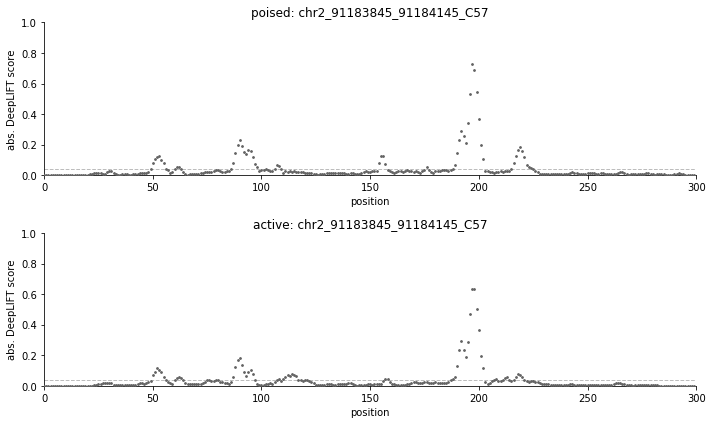

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(10,6))

OverlayVariantsGen2(control_vars,
                    poised_smooth_weights,
                    poised_data,
                    'chr2_91183845_91184145_C57',
                    'poised', ylim=1, ax=axs[0],
                    scatter_kws={'s':3, 'c':'#636363'})

OverlayVariantsGen2(control_vars,
                    active_smooth_weights,
                    active_data,
                    'chr2_91183845_91184145_C57',
                    'active', ylim=1, ax=axs[1],
                    scatter_kws={'s':3, 'c':'#636363'})

Marco

In [30]:
marco_locus = [('chr1',120527484,120527940),
               ('chr1',120451504,120452051),
               ('chr1',120517204,120533610)]

In [33]:
marco_pos = findOverlapPeaks(marco_locus[2], poised_data)

overlap found chr1_120528091_120528391_C57
overlap found chr1_120524232_120524532_C57
overlap found chr1_120519483_120519783_C57
overlap found chr1_120517625_120517925_C57
overlap found chr1_120527597_120527897_C57
overlap found chr1_120531823_120532123_C57


In [36]:
marco_pos[0][-1]

'chr1_120528091_120528391_C57'

overlap found Merged-chr1-120528241-1
overlap found Merged-chr1-120528241-1


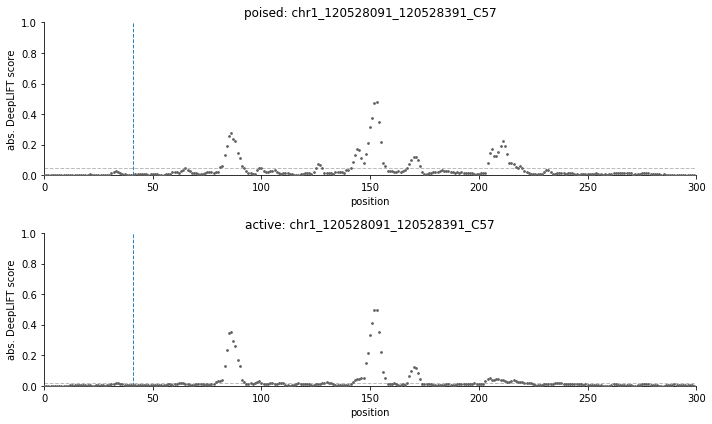

In [37]:
fig, axs = plt.subplots(2, 1, figsize=(10,6))

OverlayVariantsGen2(control_vars,
                    poised_smooth_weights,
                    poised_data,
                    marco_pos[0][-1],
                    'poised', ylim=1, ax=axs[0],
                    scatter_kws={'s':3, 'c':'#636363'})

OverlayVariantsGen2(control_vars,
                    active_smooth_weights,
                    active_data,
                    marco_pos[0][-1],
                    'active', ylim=1, ax=axs[1],
                    scatter_kws={'s':3, 'c':'#636363'})

overlap found Merged-chr1-120524369-4
overlap found Merged-chr1-120524369-4


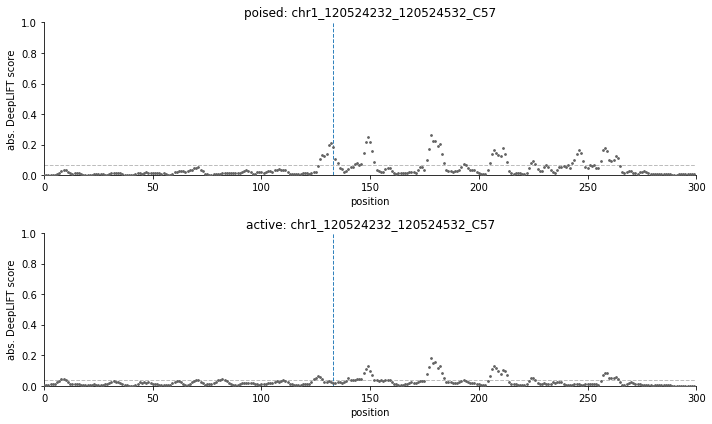

In [38]:
fig, axs = plt.subplots(2, 1, figsize=(10,6))

OverlayVariantsGen2(control_vars,
                    poised_smooth_weights,
                    poised_data,
                    marco_pos[1][-1],
                    'poised', ylim=1, ax=axs[0],
                    scatter_kws={'s':3, 'c':'#636363'})

OverlayVariantsGen2(control_vars,
                    active_smooth_weights,
                    active_data,
                    marco_pos[1][-1],
                    'active', ylim=1, ax=axs[1],
                    scatter_kws={'s':3, 'c':'#636363'})

overlap found Merged-chr1-120519635-4
overlap found Merged-chr1-120519635-4


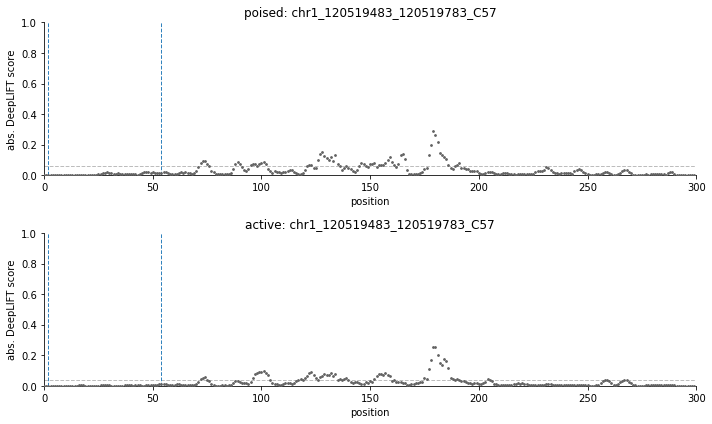

In [41]:
fig, axs = plt.subplots(2, 1, figsize=(10,6))

OverlayVariantsGen2(control_vars,
                    poised_smooth_weights,
                    poised_data,
                    marco_pos[2][-1],
                    'poised', ylim=1, ax=axs[0],
                    scatter_kws={'s':3, 'c':'#636363'})

OverlayVariantsGen2(control_vars,
                    active_smooth_weights,
                    active_data,
                    marco_pos[2][-1],
                    'active', ylim=1, ax=axs[1],
                    scatter_kws={'s':3, 'c':'#636363'})

overlap found Merged-chr1-120517755-4
overlap found Merged-chr1-120517755-4


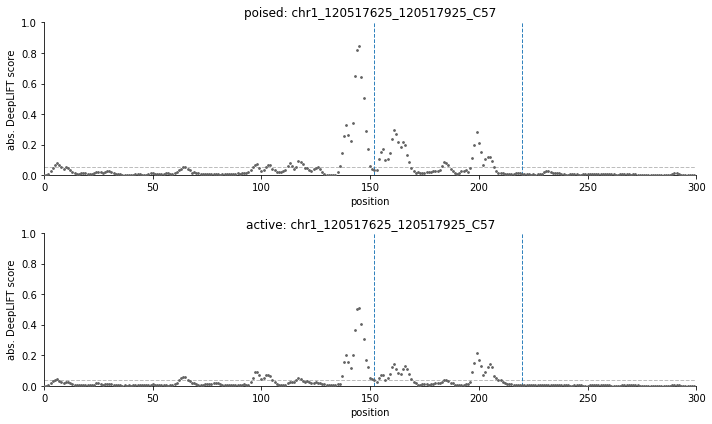

In [42]:
fig, axs = plt.subplots(2, 1, figsize=(10,6))

OverlayVariantsGen2(control_vars,
                    poised_smooth_weights,
                    poised_data,
                    marco_pos[3][-1],
                    'poised', ylim=1, ax=axs[0],
                    scatter_kws={'s':3, 'c':'#636363'})

OverlayVariantsGen2(control_vars,
                    active_smooth_weights,
                    active_data,
                    marco_pos[3][-1],
                    'active', ylim=1, ax=axs[1],
                    scatter_kws={'s':3, 'c':'#636363'})

IndexError: list index out of range

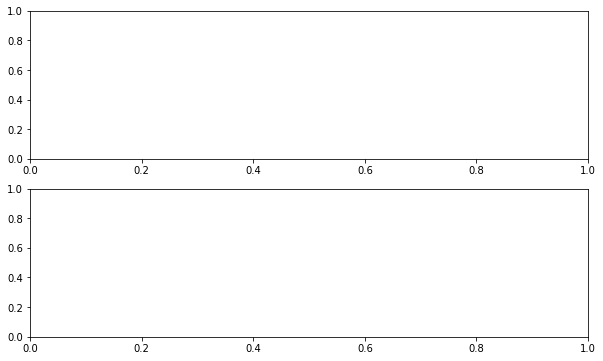

In [48]:
fig, axs = plt.subplots(2, 1, figsize=(10,6))

OverlayVariantsGen2(control_vars,
                    poised_smooth_weights,
                    poised_data,
                    marco_pos[6][-1],
                    'poised', ylim=1, ax=axs[0],
                    scatter_kws={'s':3, 'c':'#636363'})

OverlayVariantsGen2(control_vars,
                    active_smooth_weights,
                    active_data,
                    marco_pos[6][-1],
                    'active', ylim=1, ax=axs[1],
                    scatter_kws={'s':3, 'c':'#636363'})

In [47]:
marco_pos[5]

('CAGGCAGGGTCAAGGCTGGTGTAATCTGGAACAGAGAAGTGATTTTCTATTGTAGATTCTCCACCTCAGCTTGGGTCAAAATAAAATCATGGGCTTGGAAACTCCTCACTTGCATAAATAAAAATCTGCAGACTCATGGTTGGGTTTTCATATTTCAAGAGTCAAACTTTAGAAAGAACAGGGGAAGTAGGAGTGGCCTCTCATGGGGCCAGAGGACAATATCCAGGAGCCTCCTCTTCCTCGAGTTTCCCAACTTCTCAATTCTTCAGTAGCCAGCAAGAACCATCCCCGTGCAGTGTG',
 1,
 'chr1',
 120531823,
 120532123,
 'chr1_120531823_120532123_C57')